In [1]:
# Core libraries
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns 
import os
import json
import time

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, auc, precision_recall_fscore_support
)
from sklearn.utils.class_weight import compute_sample_weight

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb

# Deep Learning (Keras/TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, LeakyReLU, ELU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Saving models
import joblib


In [3]:
cic = pd.read_csv(r"C:\Users\hp\Desktop\TFG\Datasets\CIC_IDS_Merged.csv")
unsw = pd.read_csv(r"C:\Users\hp\Desktop\TFG\Datasets\UNSW_NB15.csv")

C:\Users\hp\AppData\Local\Temp\ipykernel_1004\688618902.py:2: DtypeWarning: Columns (1,3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  unsw = pd.read_csv(r"C:\Users\hp\Desktop\TFG\Datasets\UNSW_NB15.csv")


In [5]:
# Remove benign
cic = cic[cic['Label'] != 'Benign']
unsw = unsw[unsw['attack_cat'].notna() & (unsw['attack_cat'].str.strip().str.lower() != 'normal')]

# Standardize attack_cat column
unsw['attack_cat'] = unsw['attack_cat'].str.strip().str.lower()

# CIC label mapping
cic_label_map = {
    'DDoS': 'DDoS',
    'DoS': 'DoS',
    'BruteForce': 'Bruteforce',
    'Web Attack': 'Web Exploit',
    'Heartbleed': 'Web Exploit',
    'PortScan': 'Reconnaissance',
    'Botnet': 'Botnet',
    'Infiltration': 'Infiltration/Exploitation',
}
cic['LABEL'] = cic['Label'].map(cic_label_map)

# UNSW label mapping
unsw_label_map = {
    'dos': 'DoS',
    'reconnaissance': 'Reconnaissance',
    'fuzzers': 'Fuzzing',
    'generic': 'Generic',
    'backdoor': 'Botnet',
    'backdoors': 'Botnet',
    'worms': 'Botnet',
    'exploits': 'Infiltration/Exploitation',
    'shellcode': 'Infiltration/Exploitation',
}
unsw['LABEL'] = unsw['attack_cat'].map(unsw_label_map)

# Add binary attack flag
cic['is_attack'] = 1
unsw['is_attack'] = 1

# ========== 2. FEATURE ALIGNMENT ==========

# Rename CIC columns to match UNSW feature names
cic = cic.rename(columns={
    'Flow Duration': 'dur',
    'Dst Port': 'dsport',
    'Tot Fwd Pkts': 'Spkts',
    'Tot Bwd Pkts': 'Dpkts',
    'TotLen Fwd Pkts': 'sbytes',
    'TotLen Bwd Pkts': 'dbytes',
    'Fwd Pkt Len Mean': 'smeansz',
    'Bwd Pkt Len Mean': 'dmeansz',
    'Init Fwd Win Byts': 'swin',
    'Init Bwd Win Byts': 'dwin',
    'Fwd IAT Std': 'Sjit',
    'Bwd IAT Std': 'Djit'
})

# Convert UNSW timing units to microseconds
unsw['dur'] = unsw['dur'] * 1_000_000
unsw['Sjit'] = unsw['Sjit'] * 1000
unsw['Djit'] = unsw['Djit'] * 1000
unsw['Sintpkt'] = unsw['Sintpkt'] * 1000
unsw['Dintpkt'] = unsw['Dintpkt'] * 1000

# Ensure dsport is numeric
unsw['dsport'] = pd.to_numeric(unsw['dsport'], errors='coerce')

# Drop NaN dsport
unsw = unsw.dropna(subset=['dsport'])

# Derived feature engineering
def compute_derived_features(df):
    df['Flow Byts/s'] = np.where(df['dur'] != 0,
                                 (df['sbytes'] + df['dbytes']) / (df['dur'] / 1_000_000),
                                 np.nan)
    df['Flow Pkts/s'] = np.where(df['dur'] != 0,
                                 (df['Spkts'] + df['Dpkts']) / (df['dur'] / 1_000_000),
                                 np.nan)
    df['total_pkts'] = df['Spkts'] + df['Dpkts']
    df['Fwd IAT Mean'] = np.where(df['total_pkts'] != 0,
                                  (df.get('Sintpkt', 0) * df['Spkts'] + df.get('Dintpkt', 0) * df['Dpkts']) / df['total_pkts'],
                                  np.nan)
    return df

unsw = compute_derived_features(unsw)

# ========== 3. SELECT COMMON FEATURES ==========

common_features = [
    'dur', 'dsport', 'Spkts', 'Dpkts', 'sbytes', 'dbytes',
    'smeansz', 'dmeansz', 'swin', 'dwin', 'Sjit', 'Djit',
    'Flow Byts/s','Flow Pkts/s','Fwd IAT Mean','is_attack','LABEL'
]

# Keep only common features
unsw = unsw[common_features]
cic = cic[common_features]

# ========== 4. MERGE ==========

df = pd.concat([cic, unsw], axis=0).reset_index(drop=True)

In [7]:
# 1. Drop rows where duration = 0 and no traffic (regardless of label)
df = df[~((df['dur'] == 0) & (df['sbytes'] + df['dbytes'] == 0) & (df['Spkts'] + df['Dpkts'] == 0))]

# 2. Set duration to 1μs where dur == 0 (for valid rows)
df.loc[df['dur'] == 0, 'dur'] = 1

# 3. Recompute features
df['Flow Byts/s'] = (df['sbytes'] + df['dbytes']) / (df['dur'] / 1_000_000)
df['Flow Pkts/s'] = (df['Spkts'] + df['Dpkts']) / (df['dur'] / 1_000_000)

# 4. Set rates to 0 if no data or packets
df.loc[(df['sbytes'] + df['dbytes'] == 0), 'Flow Byts/s'] = 0
df.loc[(df['Spkts'] + df['Dpkts'] == 0), 'Flow Pkts/s'] = 0

# 5. Cap infinite values
df.replace([np.inf, -np.inf], 1_000_000, inplace=True)

In [9]:
# Keep only rows where dur >= 0
original_size = len(df)
df = df[df['dur'] >= 0]
print(f"Removed {original_size - len(df)} rows with negative 'dur'")

Removed 0 rows with negative 'dur'


In [11]:
# Drop rows where 'LABEL' is NaN
df = df.dropna(subset=['LABEL'])


In [13]:
label_mapping = {
    'DDoS': 0,
    'Bruteforce': 1,
    'DoS': 2,
    'Botnet': 3,
    'Generic': 4,
    'Infiltration/Exploitation': 5,
    'Reconnaissance': 6,
    'Fuzzing': 7,
    'Web Exploit': 8
}

df['LABEL'] = df['LABEL'].map(label_mapping)


In [ ]:
SPLITS HERE TRAINING

In [15]:
# 1. Split data
X = df.drop('LABEL', axis=1)
y = df['LABEL']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [17]:
# 2. FINAL MODEL
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=9,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    verbosity=1,
    max_depth=8,
    min_child_weight=3,
    gamma=0.0,
    subsample=1.0,
    colsample_bytree=0.8,
    learning_rate=0.1,
    n_estimators=300,
    reg_alpha=0.0,
    reg_lambda=1.0
)

xgb_model.fit(X_train, y_train)

# 3. Predict on original test set
start = time.time()
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)
end = time.time()
# 4. Evaluate
print("\nClassification report:")
target_names = [
    'DDoS', 'Bruteforce', 'DoS', 'Botnet',
    'Generic', 'Infiltration/Exploitation',
    'Reconnaissance', 'Fuzzing', 'Web Exploit'
]
print(f"Inference time (total): {end - start:.4f} seconds")
print(f"Inference time per sample: {(end - start) / X_test.shape[0]:.6f} seconds")
print(classification_report(y_test, y_pred, target_names=target_names))

# 5. ROC-AUC macro
y_test_bin = label_binarize(y_test, classes=range(9))
roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
print(f"ROC-AUC (macro-avg, OvR): {roc_auc:.4f}")



C:\Users\hp\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:29:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification report:
Inference time (total): 9.0449 seconds
Inference time per sample: 0.000018 seconds
                           precision    recall  f1-score   support

                     DDoS       1.00      1.00      1.00    163154
               Bruteforce       1.00      1.00      1.00     78957
                      DoS       1.00      0.95      0.98     64303
                   Botnet       1.00      0.99      1.00     58132
                  Generic       1.00      0.99      0.99     43096
Infiltration/Exploitation       0.89      0.99      0.94     41601
           Reconnaissance       1.00      0.98      0.99     34584
                  Fuzzing       0.98      0.88      0.93      4849
              Web Exploit       1.00      1.00      1.00       438

                 accuracy                           0.99    489114
                macro avg       0.98      0.98      0.98    489114
             weighted avg       0.99      0.99      0.99    489114

ROC-AUC (macro-avg,

In [21]:
# 2. Scale only for Neural Network and Logistic Regression no LOG
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
smote = SMOTE(sampling_strategy={7: 24000}, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# 3. Scale the data (only for Neural Network / Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# 4. Final Neural Network model
def create_nn(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(9, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


nn_classifier = KerasClassifier(
    build_fn=create_nn,
    input_shape=X_train_scaled.shape[1],
    epochs=50,
    batch_size=1024,
    verbose=1,
)

# 6. Train
history = nn_classifier.fit(X_train_scaled, y_train_balanced,validation_data=(X_test_scaled, y_test))

# 7. Inference timing
print("\n=== Inference ===")
start = time.time()
y_pred = nn_classifier.predict(X_test_scaled)
end = time.time()
total_time = end - start
avg_time_per_sample = total_time / X_test_scaled.shape[0]
print(f"Inference time (total): {total_time:.4f} seconds")
print(f"Inference time per sample: {avg_time_per_sample:.6f} seconds")

# 8. Prediction probabilities
y_proba = nn_classifier.predict_proba(X_test_scaled)

# 9. Classification Report
target_names = [
    'DDoS', 'Bruteforce', 'DoS', 'Botnet',
    'Generic', 'Infiltration/Exploitation',
    'Reconnaissance', 'Fuzzing', 'Web Exploit'
]

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# 10. Multi-class ROC-AUC
y_test_bin = label_binarize(y_test, classes=range(9))
roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
print(f"ROC-AUC (macro-avg, OvR): {roc_auc:.4f}")






C:\Users\hp\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8696 - loss: 0.4660 - val_accuracy: 0.9574 - val_loss: 0.1252
Epoch 2/50
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9625 - loss: 0.1176 - val_accuracy: 0.9720 - val_loss: 0.0924
Epoch 3/50
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9716 - loss: 0.0902 - val_accuracy: 0.9753 - val_loss: 0.0801
Epoch 4/50
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9754 - loss: 0.0772 - val_accuracy: 0.9773 - val_loss: 0.0716
Epoch 5/50
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9781 - loss: 0.0689 - val_accuracy: 0.9798 - val_loss: 0.0652
Epoch 6/50
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9795 - loss: 0.0641 - val_accuracy: 0.9803 - val_loss: 0.0592
Epoch 7/50
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9806 - loss: 0.0591 - val_accuracy: 0.9802 - val_loss: 0.0570
Epoch 8/50
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9813 - loss: 0.0572 - 

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import time

# Best parameters from RandomizedSearchCV
rf = RandomForestClassifier(
    n_estimators=500, 
    min_samples_split=5, 
    min_samples_leaf=1, 
    max_features='sqrt', 
    max_depth=30, 
    bootstrap=False, 
    random_state=42, 
    n_jobs=-1, 
    verbose=1
)

# Train the model
rf.fit(X_train, y_train)

# Inference timing
start = time.time()
y_proba = rf.predict_proba(X_test)  # Shape: (n_samples, n_classes)
y_pred = rf.predict(X_test)
end = time.time()

print(f"Inference time (total): {end - start:.4f} seconds")
print(f"Inference time per sample: {(end - start) / X_test.shape[0]:.6f} seconds")

# Classification report
target_names = [
    'DDoS', 'Bruteforce', 'DoS', 'Botnet',
    'Generic', 'Infiltration/Exploitation',
    'Reconnaissance', 'Fuzzing', 'Web Exploit'
]

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# ROC-AUC score
y_test_bin = label_binarize(y_test, classes=range(9))  # 9 classes
roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

print(f"ROC-AUC (macro-avg, OvR): {roc_auc:.4f}")


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.0s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    6.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.0s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed: 

Inference time (total): 12.5230 seconds
Inference time per sample: 0.000026 seconds

Classification report:
                           precision    recall  f1-score   support

                     DDoS       1.00      1.00      1.00    163154
               Bruteforce       1.00      1.00      1.00     78957
                      DoS       0.99      0.96      0.98     64303
                   Botnet       1.00      0.99      1.00     58132
                  Generic       1.00      0.99      0.99     43096
Infiltration/Exploitation       0.90      0.99      0.94     41601
           Reconnaissance       1.00      0.98      0.99     34584
                  Fuzzing       0.97      0.89      0.93      4849
              Web Exploit       1.00      0.99      0.99       438

                 accuracy                           0.99    489114
                macro avg       0.98      0.98      0.98    489114
             weighted avg       0.99      0.99      0.99    489114

ROC-AUC (macro-avg

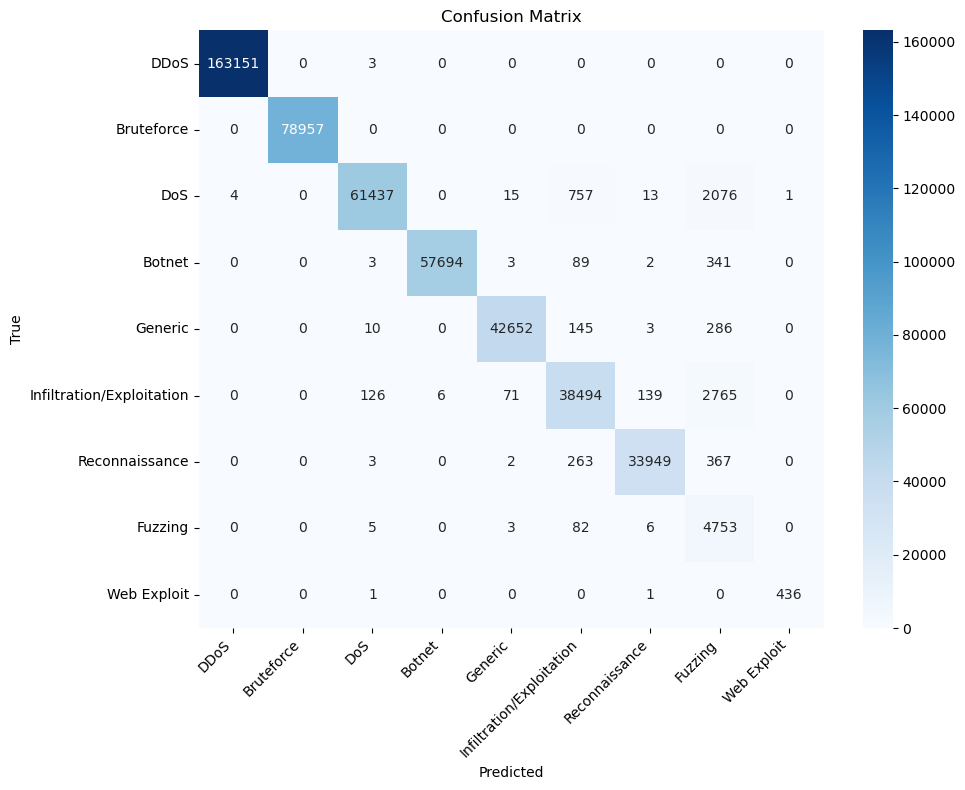

C:\Users\hp\AppData\Local\Temp\ipykernel_17996\747023627.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", 9)


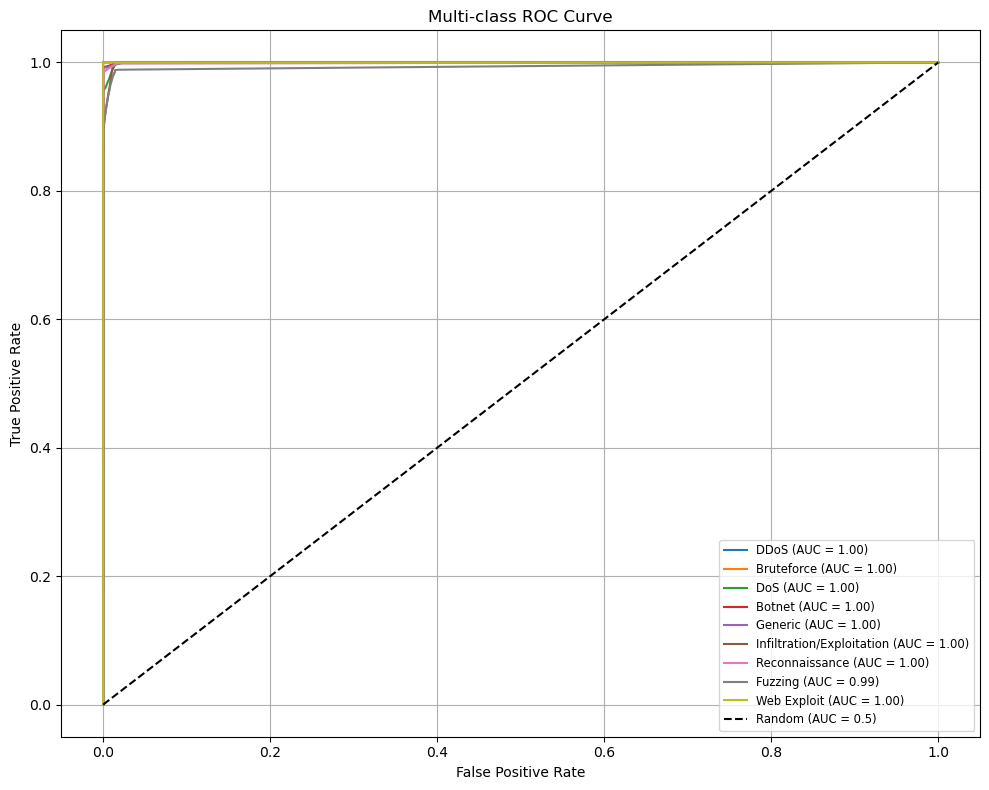

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import label_binarize

# Target class names
target_names = [
    'DDoS', 'Bruteforce', 'DoS', 'Botnet',
    'Generic', 'Infiltration/Exploitation',
    'Reconnaissance', 'Fuzzing', 'Web Exploit'
]

# 1. Plot Multi-class Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Plot ROC Curve for each class
y_test_bin = label_binarize(y_test, classes=range(9))  # one-hot encode y_test
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(9):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("tab10", 9)

for i in range(9):
    plt.plot(fpr[i], tpr[i], label=f'{target_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


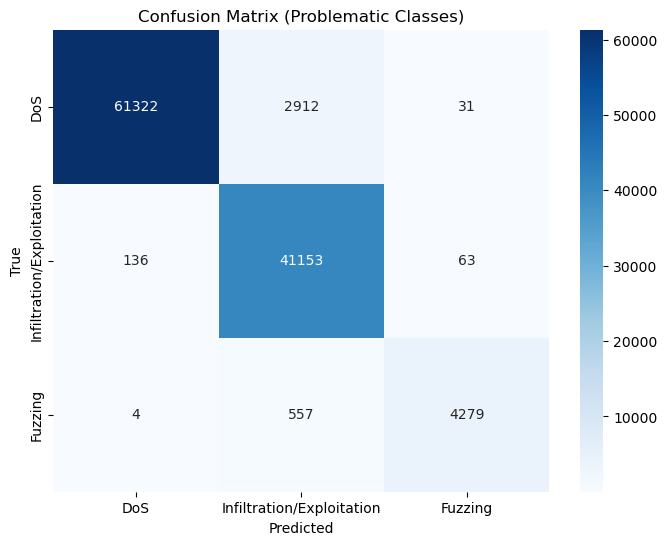

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix data (replace with your actual matrix)
conf_matrix = np.array([
    [163151, 0, 3, 0, 0, 0, 0, 0, 0],
    [0, 78957, 0, 0, 0, 0, 0, 0, 0],
    [4, 0, 61322, 0, 17, 2912, 16, 31, 1],
    [0, 0, 1, 57686, 5, 427, 3, 10, 0],
    [0, 0, 13, 0, 42590, 478, 3, 12, 0],
    [19, 0, 136, 4, 96, 41153, 130, 63, 0],
    [0, 0, 7, 1, 1, 622, 33949, 4, 0],
    [0, 0, 4, 1, 2, 557, 6, 4279, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 437]
])

classes = [
    'DDoS', 'Bruteforce', 'DoS', 'Botnet', 'Generic',
    'Infiltration/Exploitation', 'Reconnaissance', 'Fuzzing', 'Web Exploit'
]

# Plot focused heatmap for problematic classes
problematic_classes = ['DoS', 'Infiltration/Exploitation', 'Fuzzing']
indices = [classes.index(c) for c in problematic_classes]
filtered_matrix = conf_matrix[np.ix_(indices, indices)]

plt.figure(figsize=(8, 6))
sns.heatmap(filtered_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=problematic_classes, yticklabels=problematic_classes)
plt.title('Confusion Matrix (Problematic Classes)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()